# Streaming Movie Reviews

In this hands-on exercise we will look at data, which is not bounded. In many applications data is continuously updated. The data that we will be working with comes from the Internet Movie Database (IMDB) app. Users who have set their app up to connect with Twitter will automatically produce a tweet everytime they rate a movie in the app. It is possible to subscribe to tweets as they are produced, but for simplicity we will simulate this process by streaming historic data.

To work with streaming data in Spark we need to create a StreamingContext that plays a similar role to the SparkContext of a batch application. We also need to set an interval of how often we want to process data. Here we will set it to 10 seconds.

In [ ]:
from pyspark.streaming import StreamingContext
batch_interval=10
stream_context = StreamingContext(sc, batch_interval)

We can now manipulate the streaming data similarly to what we would do with batch data, but the difference is that the processing is repeated every 10 seconds with the data that have arrived since last run.

We are faking the stream of reviews by hooking up to a bucket.

In [ ]:
stream_of_reviews=stream_context.textFileStream("gs://big-data-streaming-examples")

In [ ]:

local_data={}
local_data["total_count"]=0
local_data["one_line"]=""
local_data["latest_processing_time"]=""



def count_and_keep_one(time, rdd):
    data=rdd.collect()
    local_data["latest_processing_time"]=time
    local_data["total_count"] += len(data)
    if len(data)>0:
        local_data["one_line"]=data[0]
    

stream_of_reviews.map(lambda x: x).foreachRDD(count_and_keep_one)

In [ ]:
print("Number of lines processed: "+str(local_data["total_count"]))
print("Latest processing time: "+str(local_data["latest_processing_time"]))
print("Example of a line from latest batch: "+local_data["one_line"])

In [ ]:
stream_context.start()

In [ ]:
stream_context.stop(False)

In [1]:
from pyspark.streaming import StreamingContext
import json
batchIntervalSeconds = 10
ssc = StreamingContext(sc, batchIntervalSeconds)
lines=ssc.textFileStream("gs://big-data-streaming-examples")
ratings=lines.map(lambda x: json.loads(x)["rating"]).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

rating_dist={}
for i in range(11):
    rating_dist[str(i)]=0
    
def process(time, rdd):
    for r in rdd.collect():
        rating_dist[str(r[0])]+=r[1]
    
ratings.foreachRDD(process)


In [2]:
ssc.start()

In [21]:
ssc.stop(False)

In [18]:
rating_dist

{'0': 0,
 '1': 27,
 '2': 24,
 '3': 37,
 '4': 75,
 '5': 123,
 '6': 263,
 '7': 443,
 '8': 505,
 '9': 310,
 '10': 274}

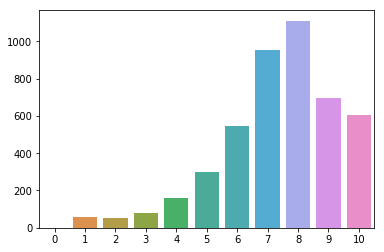

In [20]:
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.barplot(data=pd.DataFrame([rating_dist.values()]))